In [1]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
class SoilResNet:
    """
    A class for implementing ResNet for soil image classification.
    
    Attributes:
    -----------
    train_dir : str
        Path to the directory containing the training set.
    validation_dir : str
        Path to the directory containing the validation set.
    test_dir : str
        Path to the directory containing the test set.
    """
    
    def __init__(self, train_dir, validation_dir, test_dir):
        self.train_dir = train_dir
        self.validation_dir = validation_dir
        self.test_dir = test_dir
        self.num_classes = len(os.listdir(train_dir))
        self.target_size = (100, 100)  # ResNet's input size
        self.batch_size = 12  ##10
        self.epochs = 100
        self.model = None

        # Set random seeds for reproducibility
        self.set_random_seeds()
    
    def set_random_seeds(self, seed_value=42):
        """
        Set random seeds for reproducibility.
        
        Parameters:
        -----------
        seed_value : int
            The seed value to use for all random number generators.
        """
        os.environ['PYTHONHASHSEED'] = str(seed_value)
        random.seed(seed_value)
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
    
    def build_model(self):
        """
        Build the ResNet model.
        """
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

        # Freeze all the layers initially
        for layer in base_model.layers:
            layer.trainable = False

        # Unfreeze the last few layers for fine-tuning
        for layer in base_model.layers[-9:]:  # Fine-tuning fewer layers #10
            layer.trainable = True

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)  # Reduced number of units
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)  # Reduced number of units
        x = Dense(64, activation='relu')(x)  # Reduced number of units
        x = Dense(self.num_classes, activation='softmax')(x)

        self.model = Model(inputs=base_model.input, outputs=x)
    
    def compile_model(self):
        """
        Compiles the ResNet model.
        """
        initial_learning_rate = 0.00001 #0.000001
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=10000,
            decay_rate=0.96,
            staircase=True
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=1e-3) #1e-4
        self.model.compile(optimizer=optimizer,
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    
    def train_model(self):
        """
        Trains the ResNet model.
        """
        self.compile_model()

        train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

        train_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='categorical'
        )

        validation_generator = test_datagen.flow_from_directory(
            self.validation_dir,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='categorical'
        )

        checkpoint = ModelCheckpoint('soil_resnet_model.h5',
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)

        history = self.model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // self.batch_size,
            epochs=self.epochs,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // self.batch_size,
            callbacks=[checkpoint]
        )

        self.plot_training_history(history)
        return history

    def plot_training_history(self, history):
        """
        Plots the training and validation accuracy and loss curves.
        
        Parameters:
        -----------
        history : keras History
            History object containing training/validation metrics.
        """
        def smooth_curve(points, factor=0.9):
            smoothed_points = []
            for point in points:
                if smoothed_points:
                    previous = smoothed_points[-1]
                    smoothed_points.append(previous * factor + point * (1 - factor))
                else:
                    smoothed_points.append(point)
            return smoothed_points

        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(smooth_curve(history.history['accuracy']), label='Training Accuracy')
        plt.plot(smooth_curve(history.history['val_accuracy']), label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(smooth_curve(history.history['loss']), label='Training Loss')
        plt.plot(smooth_curve(history.history['val_loss']), label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.show()
    
    def evaluate_model(self):
        """
        Evaluate the trained ResNet model on the test set and print the test accuracy.
        """
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_generator = test_datagen.flow_from_directory(
            self.test_dir,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False
        )
        
        self.model = tf.keras.models.load_model("soil_resnet_model.h5")
        
        start_time = time.time()
        test_loss, test_accuracy = self.model.evaluate(test_generator, verbose=1)
        end_time = time.time()
        
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
        print(f"Time taken to evaluate the model: {end_time - start_time} seconds")

## MODELING

Found 1096 images belonging to 4 classes.
Found 99 images belonging to 4 classes.
Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 1.2222 - accuracy: 0.4954
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to soil_resnet_model.h5


/Users/pranavramesh/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 [==============================] - 17s 167ms/step - loss: 1.2222 - accuracy: 0.4954 - val_loss: 1.2205 - val_accuracy: 0.4167
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 1.0270 - accuracy: 0.6135
Epoch 2: val_accuracy improved from 0.41667 to 0.55208, saving model to soil_resnet_model.h5
91/91 [==============================] - 14s 159ms/step - loss: 1.0270 - accuracy: 0.6135 - val_loss: 1.0475 - val_accuracy: 0.5521
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.9436 - accuracy: 0.6282
Epoch 3: val_accuracy improved from 0.55208 to 0.58333, saving model to soil_resnet_model.h5
91/91 [==============================] - 16s 172ms/step - loss: 0.9436 - accuracy: 0.6282 - val_loss: 0.8532 - val_accuracy: 0.5833
Epoch 4/100
91/91 [==============================] - ETA: 0s - loss: 0.8911 - accuracy: 0.6458
Epoch 4: val_accuracy improved from 0.58333 to 0.65625, saving model to soil_resnet_model.h5
91/91 [==============================] -

91/91 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.8579
Epoch 29: val_accuracy did not improve from 0.85417
91/91 [==============================] - 16s 174ms/step - loss: 0.4066 - accuracy: 0.8579 - val_loss: 0.3934 - val_accuracy: 0.8125
Epoch 30/100
91/91 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.8496
Epoch 30: val_accuracy improved from 0.85417 to 0.86458, saving model to soil_resnet_model.h5
91/91 [==============================] - 16s 177ms/step - loss: 0.4095 - accuracy: 0.8496 - val_loss: 0.3718 - val_accuracy: 0.8646
Epoch 31/100
91/91 [==============================] - ETA: 0s - loss: 0.3981 - accuracy: 0.8625
Epoch 31: val_accuracy improved from 0.86458 to 0.88542, saving model to soil_resnet_model.h5
91/91 [==============================] - 17s 190ms/step - loss: 0.3981 - accuracy: 0.8625 - val_loss: 0.3269 - val_accuracy: 0.8854
Epoch 32/100
91/91 [==============================] - ETA: 0s - loss: 0.4022 - accuracy: 

91/91 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.8939
Epoch 58: val_accuracy did not improve from 0.88542
91/91 [==============================] - 16s 178ms/step - loss: 0.2986 - accuracy: 0.8939 - val_loss: 0.3758 - val_accuracy: 0.8542
Epoch 59/100
91/91 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.8875
Epoch 59: val_accuracy did not improve from 0.88542
91/91 [==============================] - 16s 176ms/step - loss: 0.3114 - accuracy: 0.8875 - val_loss: 0.3611 - val_accuracy: 0.8750
Epoch 60/100
91/91 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.9050
Epoch 60: val_accuracy did not improve from 0.88542
91/91 [==============================] - 16s 174ms/step - loss: 0.2877 - accuracy: 0.9050 - val_loss: 0.3808 - val_accuracy: 0.8542
Epoch 61/100
91/91 [==============================] - ETA: 0s - loss: 0.2909 - accuracy: 0.8948
Epoch 61: val_accuracy did not improve from 0.88542
91/91 [==================

91/91 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9068
Epoch 87: val_accuracy did not improve from 0.90625
91/91 [==============================] - 15s 170ms/step - loss: 0.2597 - accuracy: 0.9068 - val_loss: 0.4139 - val_accuracy: 0.8646
Epoch 88/100
91/91 [==============================] - ETA: 0s - loss: 0.2542 - accuracy: 0.9068
Epoch 88: val_accuracy did not improve from 0.90625
91/91 [==============================] - 16s 172ms/step - loss: 0.2542 - accuracy: 0.9068 - val_loss: 0.3588 - val_accuracy: 0.8646
Epoch 89/100
91/91 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9077
Epoch 89: val_accuracy did not improve from 0.90625
91/91 [==============================] - 16s 171ms/step - loss: 0.2618 - accuracy: 0.9077 - val_loss: 0.3539 - val_accuracy: 0.8750
Epoch 90/100
91/91 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.9068
Epoch 90: val_accuracy did not improve from 0.90625
91/91 [==================

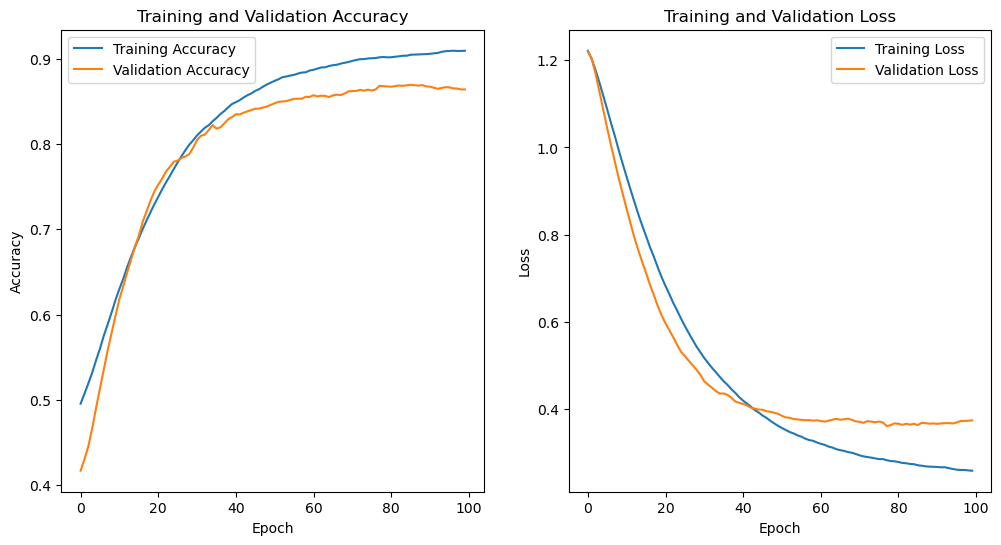

Found 97 images belonging to 4 classes.


9/9 [==============================] - 1s 112ms/step - loss: 0.3173 - accuracy: 0.8763
Test Accuracy: 87.63%
Time taken to evaluate the model: 1.3376798629760742 seconds


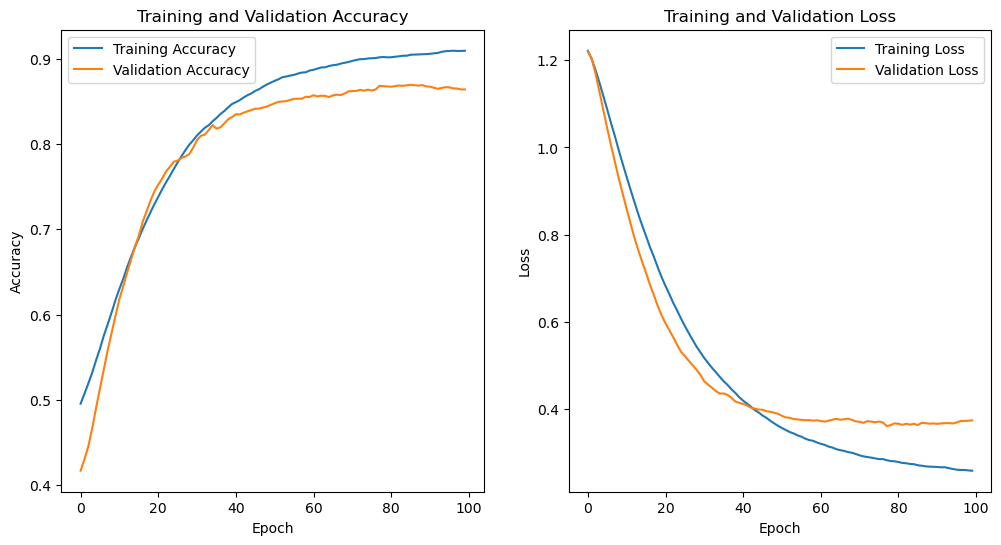

In [3]:
if __name__ == "__main__":
    # Build, train, and evaluate ResNet model
    resnet_model = SoilResNet(train_dir='train_test_val/train',
                              validation_dir='train_test_val/validation',
                              test_dir='train_test_val/test')
    resnet_model.build_model()
    history = resnet_model.train_model()
    resnet_model.evaluate_model()

    # Plot the smoothed training history
    resnet_model.plot_training_history(history)